In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd
import os

In [2]:
# load data
from scipy.io import loadmat

# sampling frequency from paper
fs = 2000
ninapro_root = "./Ninapro/DB1"
print(os.path.abspath(ninapro_root))

ex1_file = os.path.join(ninapro_root, "S2_A1_E1.mat")

data = loadmat(ex1_file)

# Inspect available keys
print(data.keys())

# Ninapro EMG data is usually stored under key 'emg' or similar
emg = data['emg']

data_shape = emg.shape
n_timepoints = emg.shape[0]
n_channels = emg.shape[1]

print(f'The shape of the data is {data_shape}')
print(f'There are {n_timepoints} timepoints')
print(f'There are {n_channels} channels')


/data/Ninapro/DB1
dict_keys(['__header__', '__version__', '__globals__', 'subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition'])
The shape of the data is (100686, 10)
There are 100686 timepoints
There are 10 channels


## 1) Visualization and Preprocessing

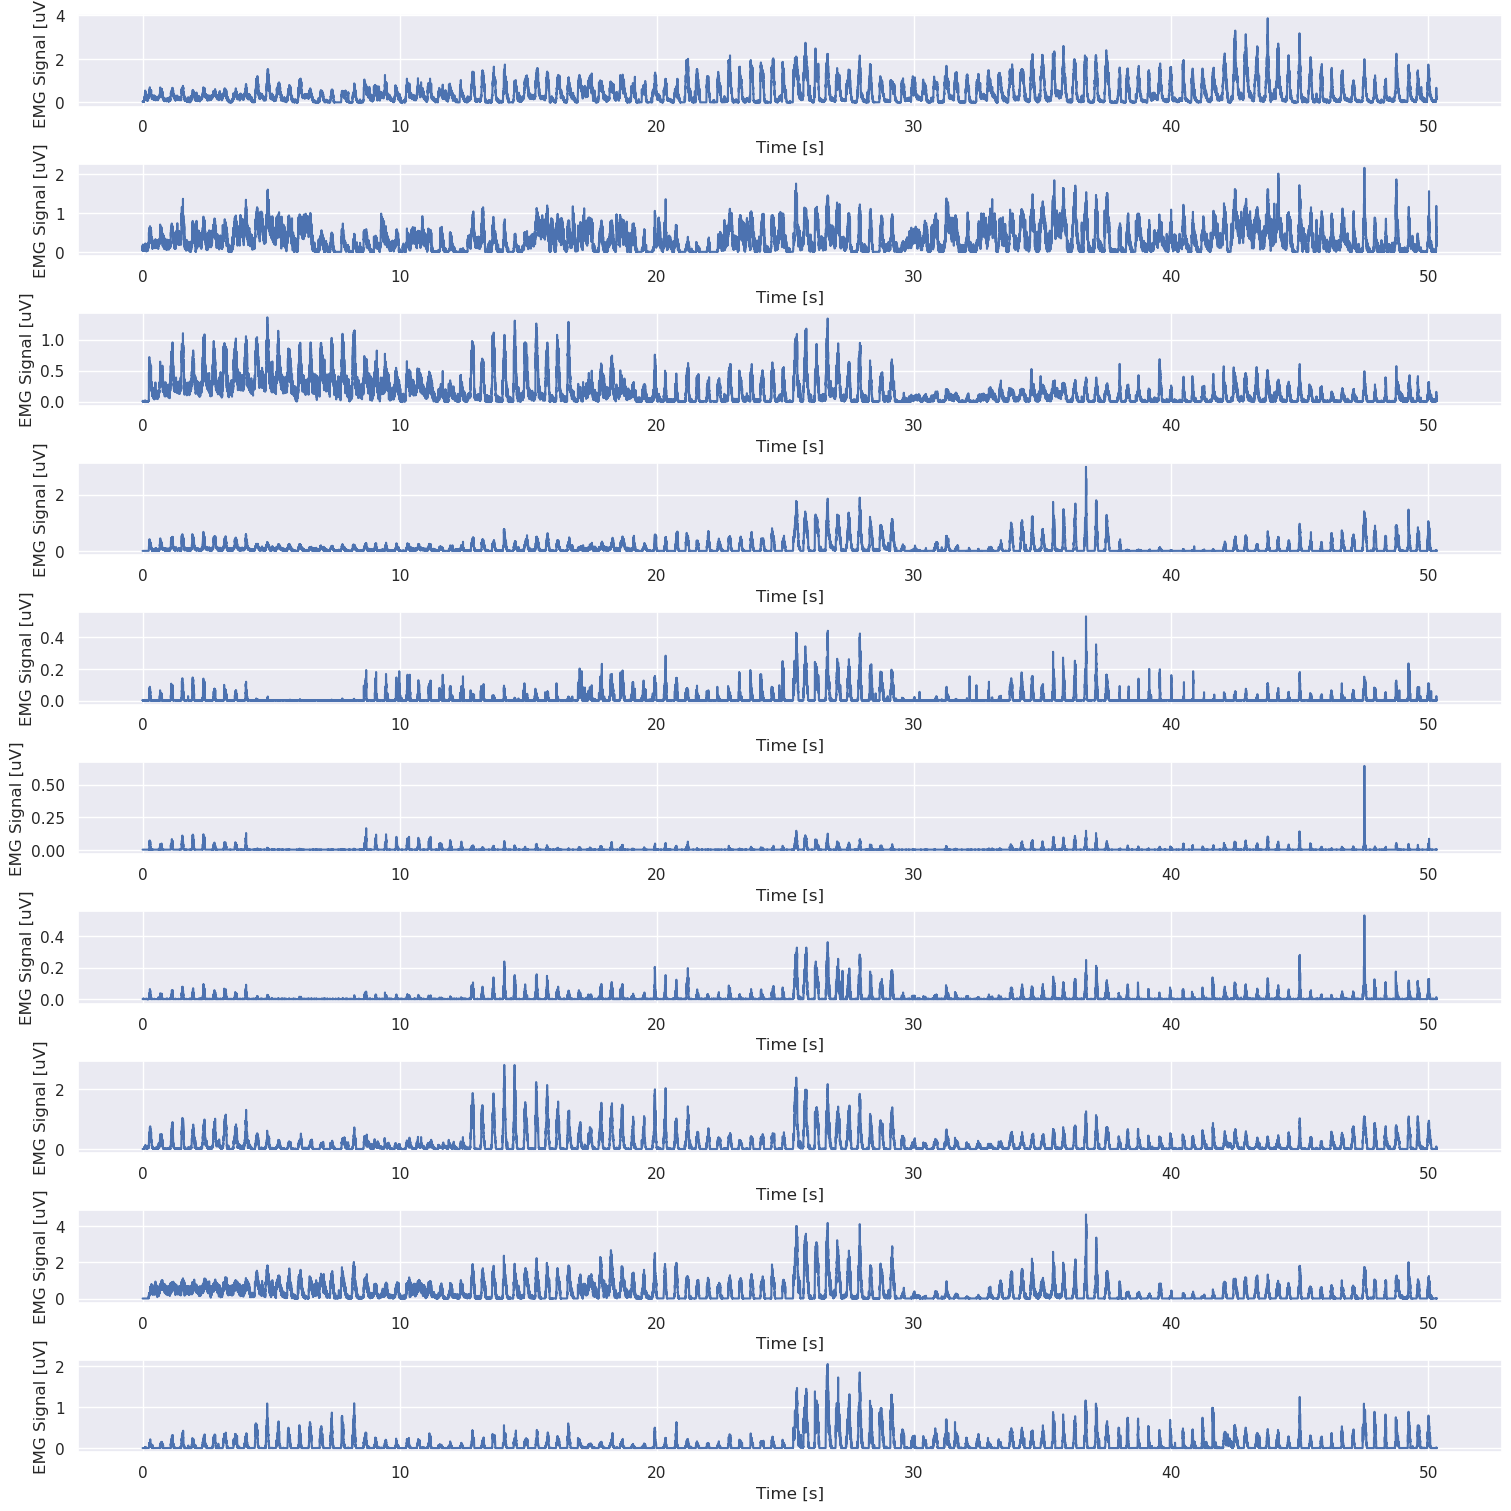

In [3]:
# visualize signals
n_channels = emg.shape[1]

#Time vector for plotting : create evenly spaced time bins from 0 to the total duration of the signal in s
time_steps = np.arange(0,emg.shape[0]/fs, 1/fs)

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel("EMG Signal [uV]")

In [4]:
# data is already partly preprocessed !!!
emg_rectified = data["emg"].copy()

#Restimulus and rerepetition are the stimulus and repetition that have been processed for better correspondance to real movement
#Stimulus is the type of movement that is being performed
stimulus = data["restimulus"] 
#Repetition is the number of times the movement has been repeated
repetition = data["rerepetition"] 

print(f'What are the shape of the data that we are working with? \nEMG: {emg_rectified.shape}, \nStimulus {stimulus.shape}, \nRepetition {repetition.shape}')

What are the shape of the data that we are working with? 
EMG: (100686, 10), 
Stimulus (100686, 1), 
Repetition (100686, 1)


In [5]:
# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1 
n_channels = emg_rectified.shape[1]

print(f'How many types of movement are there? {n_stimuli}') 
print(f'How many repetitions are there? {n_repetitions}') 

How many types of movement are there? 12
How many repetitions are there? 10


In [6]:
# different number of samples for different trials
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

number_of_samples_per_trial

array([[307., 390., 262., 226., 418., 204., 196., 270., 306., 489.],
       [334., 323., 344., 309., 333., 376., 362., 307., 348., 339.],
       [465., 352., 450., 460., 436., 389., 323., 388., 383., 316.],
       [310., 402., 357., 396., 255., 333., 263., 369., 438., 471.],
       [516., 382., 425., 379., 463., 411., 387., 343., 286., 377.],
       [337., 319., 337., 368., 338., 336., 268., 354., 319., 313.],
       [428., 392., 341., 393., 421., 445., 342., 328., 329., 358.],
       [289., 372., 406., 397., 498., 336., 415., 328., 472., 405.],
       [384., 424., 371., 316., 280., 314., 342., 284., 307., 421.],
       [311., 296., 299., 296., 301., 246., 213., 317., 493., 221.],
       [352., 403., 338., 416., 330., 355., 313., 322., 329., 219.],
       [270., 330., 300., 387., 295., 204., 363., 267., 281., 329.]])

In [8]:
# visualize a single trial
#defining the length of the moving average window
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg_rectified[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0) 

Text(0.5, 0.98, 'Envelopes of the EMG signal')

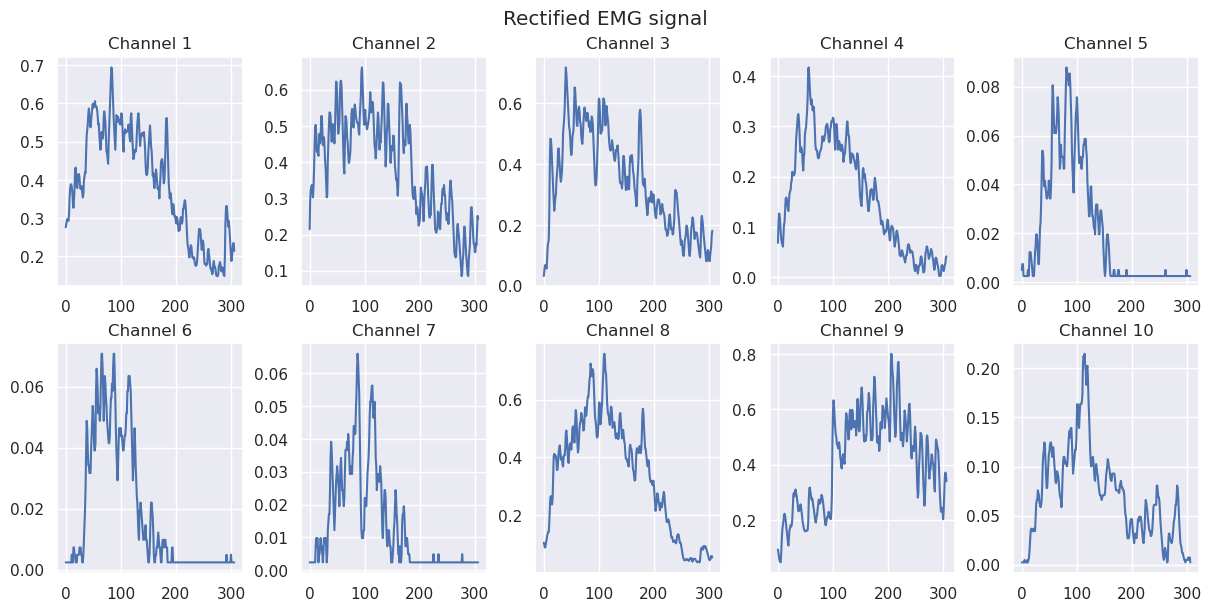

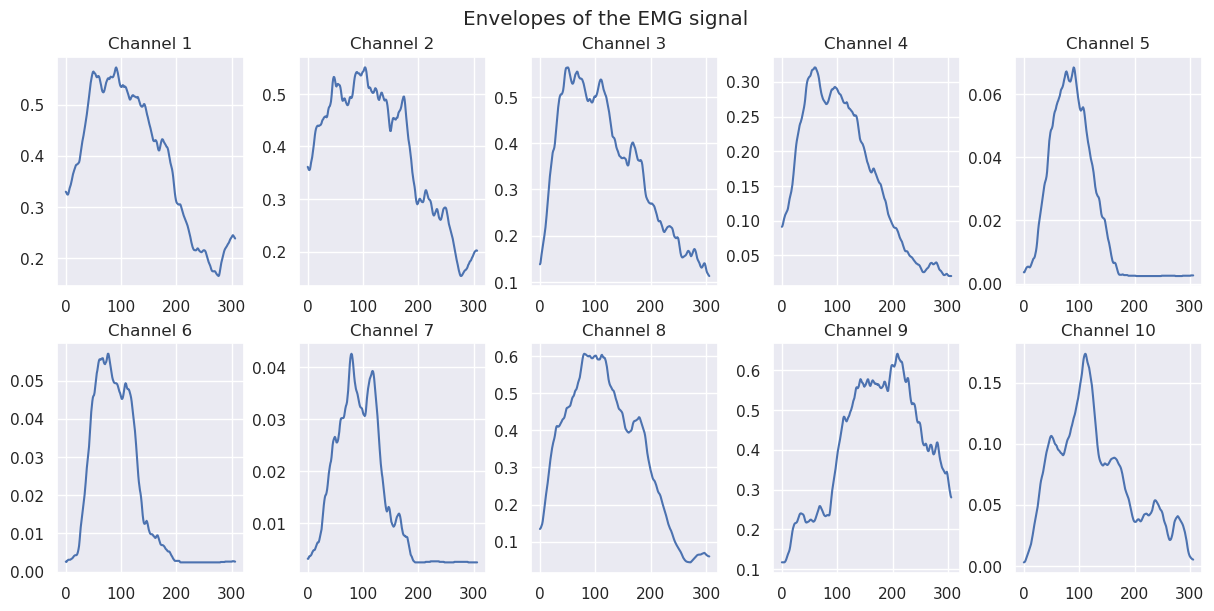

In [8]:

fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()

#10 EMG channels
number_of_emg_channels = emg_rectified.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")

Text(0.5, 0.98, 'Envelopes of the EMG signal')

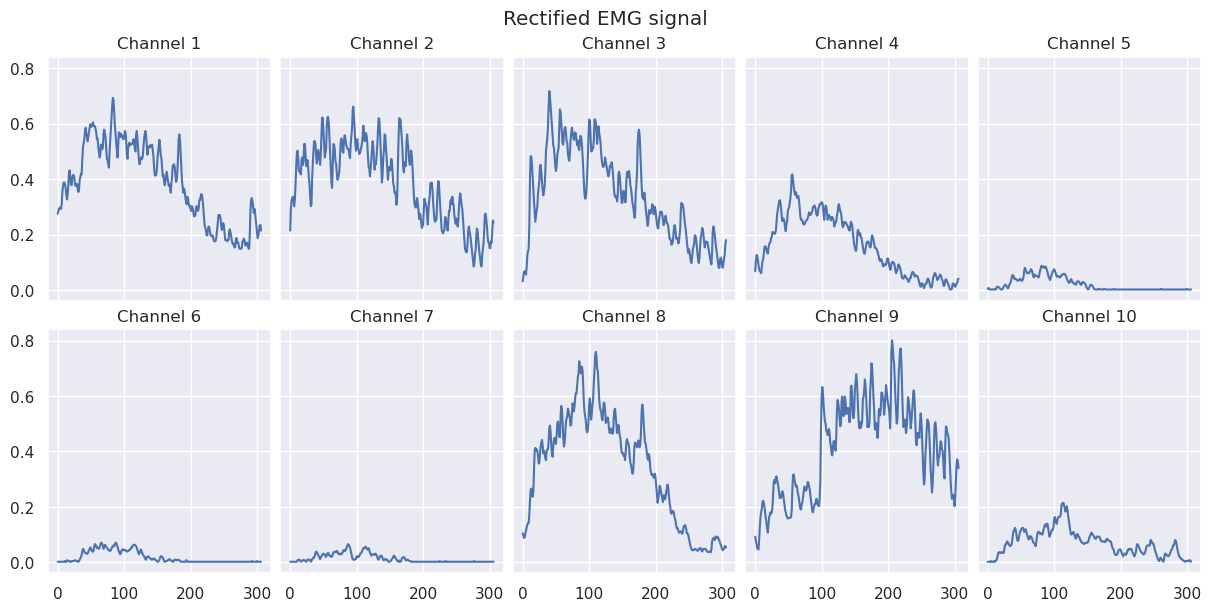

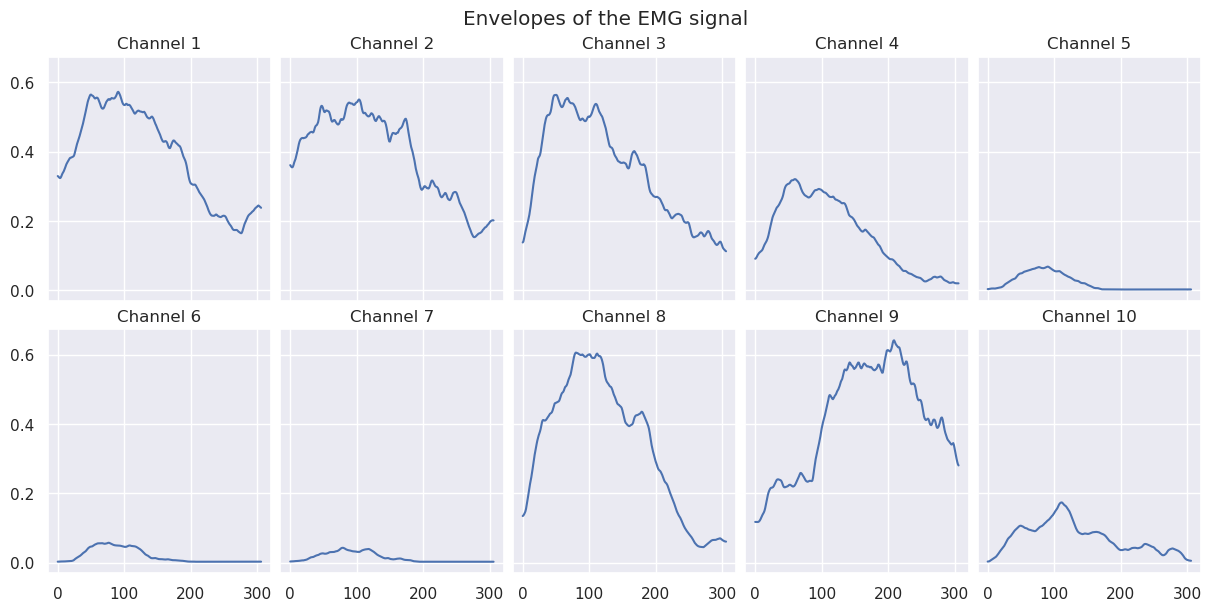

In [9]:
# Now we plot all the channels on the same y-scale
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

number_of_emg_channels = emg_rectified.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")

In [10]:
# instead of just one trial, look at all of them 
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        #mean across time for each channel
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0) 

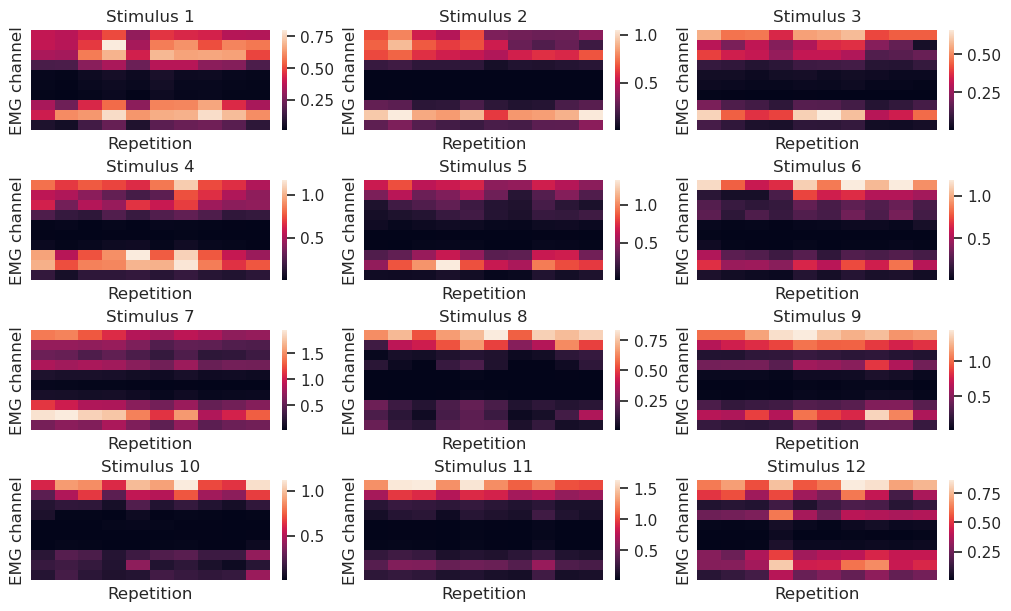

In [11]:
fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

Does the data look reasonable? Did you need to remove any trials?
j'ai l'impression que ça va on peut tous les garder pt être ? même bla bla que série 10b

## 2) Split data and extract features

In [12]:
# comme série 11 je pense, c'est la même data en plus
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

In [13]:
# define and implement features, add more features !!!!!!
 

# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis = 0) 

# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0) 
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum(((x[1:-1] - x[:-2]) * (x[1:-1] - x[2:]) > 0),axis=0)


#Feel free to add more features, e.g. frequency domain features from the two papers 


dataset, labels = build_dataset_from_ninapro(
    emg=emg,
    stimulus=stimulus,
    repetition=repetition,
    
    features=[mav, std, maxav, rms, wl, ssc] # Uncomment this line to use all features once implemented
)

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")
# visualize !!!!!!

dataset dimension: (120, 60)
labels dimension: (120,)


In [14]:
# split data, 70% train 15 and 15% val and test
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(dataset, labels, test_size=0.3, stratify = labels)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify = y_temp)

## Classification

In [15]:
# first just baseline model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

print("Baseline accuracy:", rf.score(X_val, y_val))


Baseline accuracy: 0.8888888888888888


In [16]:
# now hyperparameter optimization to find best model
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [200, 400, 600],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

rf = RandomForestClassifier()

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                 # 5-fold cross validation
    scoring="accuracy",   # optimize accuracy
    n_jobs=-1,            # use all cores
    verbose=1
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best CV accuracy: 0.8941176470588236


In [17]:
best_rf = grid.best_estimator_

val_acc = best_rf.score(X_val, y_val)
test_acc = best_rf.score(X_test, y_test)

print("Validation accuracy:", val_acc)
print("Test accuracy:", test_acc)


Validation accuracy: 0.9444444444444444
Test accuracy: 0.8333333333333334


In [18]:
# metrics F1 or accuracy ?
from sklearn.metrics import f1_score, accuracy_score

y_pred = best_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1-score:", f1_score(y_test, y_pred, average='macro'))


Accuracy: 0.8333333333333334
Macro F1-score: 0.6888888888888888


## Feature selection

Estimated mutual information between each feature and the target:
[0.66622325 0.28297822 0.79669544 0.86232456 0.8273865  0.51206045
 0.57677933 0.55397591 0.71440983 0.66239723 0.72250163 0.21883895
 0.83798561 0.8453275  0.62089446 0.51157842 0.62016288 0.69414139
 0.87714488 0.59919609 0.84742022 0.50953816 0.62774662 0.83092782
 0.6065367  0.58370798 0.59878331 0.54268939 0.70856485 0.64293465
 0.67959342 0.31567593 0.76797635 0.90402699 0.76476364 0.51275587
 0.64494917 0.61457738 0.75767963 0.63374612 0.55987637 0.09616808
 0.80242218 0.93359067 0.93654084 0.72156365 0.72086886 0.61584889
 0.78142517 0.68338708 0.04213067 0.10711503 0.19090589 0.39613302
 0.70871015 0.58893822 0.56245271 0.24535807 0.42703733 0.11320541]

Macro-F1 score with mutual information feature selection: 0.6333333333333333


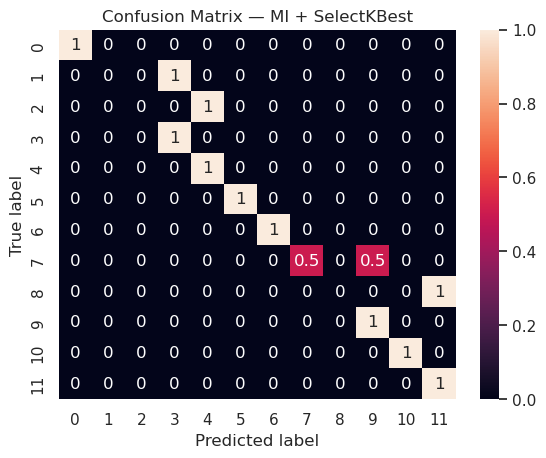

In [22]:
# method 1: mutual info + select K best like in lab
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import  confusion_matrix

# Calculate mutual information between each feature and the target variable
mutual_info = mutual_info_classif(X_train, y_train)
print(f"Estimated mutual information between each feature and the target:\n{mutual_info}\n")

# Select the top 3 features based on mutual information scores
k_best = SelectKBest(mutual_info_classif, k=10)
k_best.fit(X_train, y_train)

# Transform the datasets to only include the selected features
X_train_best = k_best.transform(X_train)
X_test_best = k_best.transform(X_test)

# Train a Random Forest using the best parameters from GridSearch
clf = RandomForestClassifier(**grid.best_params_, random_state=42)
clf.fit(X_train_best, y_train)

# Predict labels for the test set.
y_pred = clf.predict(X_test_best)

# Evaluate performance: macro F1 score.
f1_mi = f1_score(y_test, y_pred, average="macro")
print(f"Macro-F1 score with mutual information feature selection: {f1_mi}")

# Confusion matrix.
confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix — MI + SelectKBest")
plt.show()


PCA reduced dimensionality from 60 to 8 components
Macro-F1 score with PCA: 0.5833333333333334


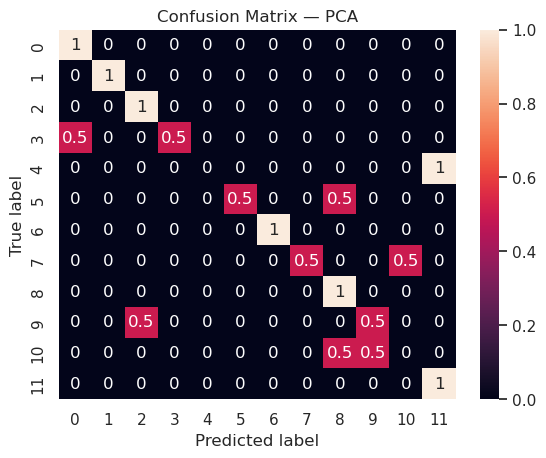

In [21]:
# method 2 : PCA 


from sklearn.decomposition import PCA

# Keep enough components to explain ~95% variance
pca = PCA(n_components=0.95)  
pca.fit(X_train)

# Transform the data
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"PCA reduced dimensionality from {X_train.shape[1]} to {X_train_pca.shape[1]} components")

# Train Random Forest using PCA features.
clf_pca = RandomForestClassifier(**grid.best_params_)
clf_pca.fit(X_train_pca, y_train)

# Predict labels.
y_pred_pca = clf_pca.predict(X_test_pca)

# Evaluate performance.
f1_pca = f1_score(y_test, y_pred_pca, average="macro")
print(f"Macro-F1 score with PCA: {f1_pca}")

# Confusion matrix.
confmat2 = confusion_matrix(y_test, y_pred_pca, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat2, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.title("Confusion Matrix — PCA")
plt.show()
